# Introduction

Assume you are a 8th grade student with a bit of tough luck in critical thinking and civic engagement skills.

Teachers don’t have nearly enough time to help every student with their practice work. That’s where our project comes into play. Our project helps to evaluate how effective an argument (for eg. debate) is based on the semantics and the context of the same.

You have your teachers, you have your assignments, homeworks, classworks and sessions. But that’s not nearly enough to get better at something new now is it? That right there seems to be a problem to me that hasn’t found a proper solution yet.

What you need is practice. Is it not? Well if you know that’s what you need then where is the problem in following through? One thing that does cross mind is who will check your work.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.1 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

#preprocess
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from transformers import create_optimizer

# model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import RNN, Input
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,LSTM,GRU,Embedding
from tensorflow.keras.preprocessing import sequence

from prettytable import PrettyTable
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Table of Contents

0. Exploratory Data Analysis


1. Preprocessing Data
    1. Remove punctuations
    2. Lower Casing
    3. Remove stop words
    4. Lemmatization
    5. Stemming
    
    
2. Tokenizing data
    1. Whitespace tokenizer
    2. Sub word tokenizer
    3. Tensorflow tokenizer


3. Generating embeddings
    1. Word2Vec
    2. ELMO
    3. BERT


4. Modelling
    1. GRU
    2. LSTM
    3. Seq2Seq
    4. Transformers (BERT)
    
    
5. Evaluation
    1. Accuracy
    2. Confusion Matrix
    3. Perplexity


6. Conclusion
7. Future Scope

# Reading in and viewing data

In [3]:
!unzip /content/feedback-prize-effectiveness.zip

Archive:  /content/feedback-prize-effectiveness.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test/D72CB1C11673.txt   
  inflating: train.csv               
  inflating: train/00066EA9880D.txt  
  inflating: train/000E6DE9E817.txt  
  inflating: train/0016926B079C.txt  
  inflating: train/00203C45FC55.txt  
  inflating: train/0029F4D19C3F.txt  
  inflating: train/0045BE2791A2.txt  
  inflating: train/004AC288D833.txt  
  inflating: train/0056F3D261D5.txt  
  inflating: train/007ACE74B050.txt  
  inflating: train/007E0CBA8852.txt  
  inflating: train/008C457C8E0B.txt  
  inflating: train/00944C693682.txt  
  inflating: train/00B144412785.txt  
  inflating: train/00BD97EA4041.txt  
  inflating: train/00C6E82FE5BA.txt  
  inflating: train/00D304153840.txt  
  inflating: train/00E3F86E3E6A.txt  
  inflating: train/013B9AA6B9DB.txt  
  inflating: train/0158970BC5D2.txt  
  inflating: train/015BB7DA58EE.txt  
  inflating: train/0167BBA84E43.txt 

In [4]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [5]:
train.head(10)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate
5,36a565e45db7,007ACE74B050,"though some say that life on Mars does exist, ...",Rebuttal,Ineffective
6,fb65fe816ba3,007ACE74B050,"It says in paragraph 7, on April 5, 1998, Mars...",Evidence,Adequate
7,4e472e2584fa,007ACE74B050,Everyone who thought it was made by alieans ev...,Counterclaim,Adequate
8,28a94d3ee425,007ACE74B050,Though people were not satified about how the ...,Concluding Statement,Adequate
9,d226f06362f5,00944C693682,Limiting the usage of cars has personal and pr...,Lead,Effective


In [6]:
temp = train.essay_id.value_counts().reset_index()
temp = temp[temp['essay_id'] > 6]
essays = temp['index'].to_list()
filtered_essays = [essay for essay in essays if essay != 'B5113469D13C']
indx = np.random.randint(0,len(filtered_essays)-2)
temp = train[train['essay_id'] == filtered_essays[indx]]
temp['user'] = 0
temp = temp.rename(columns={'discourse_text': 'text', 'discourse_type': 'type', 'discourse_effectiveness': 'form'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [7]:
temp

,discourse_id,essay_id,text,type,form,user
3341,45cc778bd831,3C9D9C9C1A16,"In ""The Challenge of Exploring Venus,""the auth...",Position,Ineffective,0
3342,8e51a0790934,3C9D9C9C1A16,Since Venus is the closet planet to Earth in t...,Evidence,Adequate,0
3343,503e3955480d,3C9D9C9C1A16,Some dangerous this planet planet presents,Claim,Adequate,0
3344,5607aadd7ffc,3C9D9C9C1A16,the atmosphere is thick and is almost 97 perce...,Evidence,Adequate,0
3345,79d4ccfad82a,3C9D9C9C1A16,This dangerous can really affect humans and hu...,Claim,Adequate,0
3346,e31d22643b42,3C9D9C9C1A16,Scientists believe Venus was once covered larg...,Evidence,Ineffective,0
3347,6d02241179a8,3C9D9C9C1A16,scientists are now able to knwo more about tec...,Claim,Adequate,0
3348,91c24afc9cc4,3C9D9C9C1A16,"Now, we know it's surface is rocky sediment an...",Evidence,Adequate,0
3349,2af9dfdc40a0,3C9D9C9C1A16,"In conclusion, I think the more we learn the m...",Concluding Statement,Adequate,0


# Exploratory Data Analysis

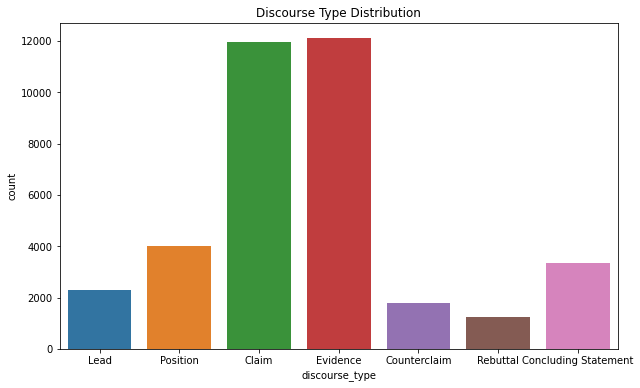

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data = train, x = "discourse_type")
plt.title("Discourse Type Distribution")
plt.show()

The Claim and Evidence discourse types are much higher compared to others. 

It is evident that these two are repeated mutiple times during the same argument going back and forth while the discourse types like lead, counter-claim and concluding statement are done a lot fewer times.

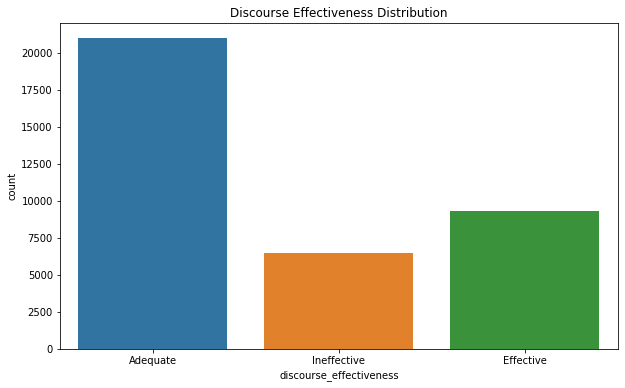

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data = train, x = "discourse_effectiveness")
plt.title("Discourse Effectiveness Distribution")
plt.show()

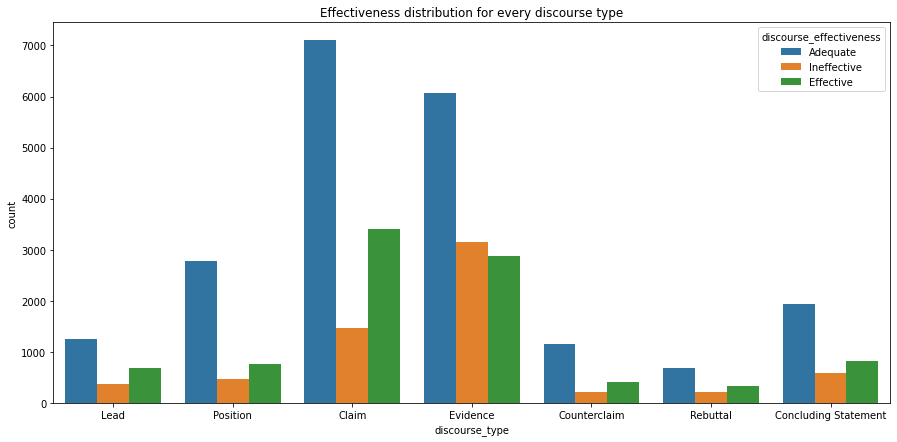

In [10]:
plt.figure(figsize=(15,7))
sns.countplot(data = train, x = 'discourse_type', hue='discourse_effectiveness')
plt.title("Effectiveness distribution for every discourse type")
plt.show()

While the distribution of effective for the different discourse types remain almost identical, the only out of ordinary observation is that the share of effective arguments is lower than ineffective arguments when it comes to presenting evidence.

It's a much shard difference compared to the ratio in discourse types like Claim and Lead.

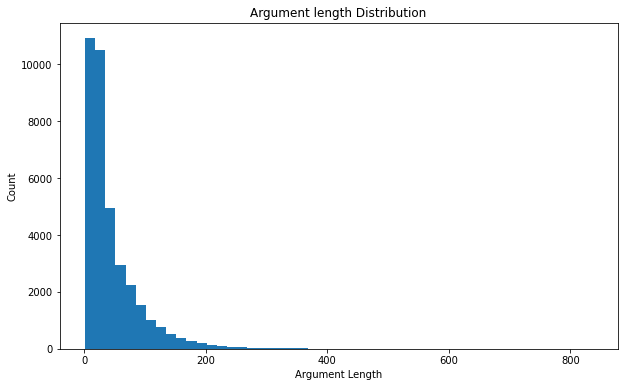

In [11]:
word_lengths = train['discourse_text'].apply(lambda t: len(t.split()))

plt.figure(figsize=(10,6))
plt.hist(word_lengths, bins=50)
plt.title("Argument length Distribution")
plt.xlabel("Argument Length")
plt.ylabel("Count")
plt.show()

# Preprocessing Data

In [12]:
#remove punctuations

def remove_punctuations(s):
    return ''.join([i for i in s if i not in [',', '.']])

In [13]:
#lower casing words

def lower_case(s):
    return s.lower()

In [14]:
# removing stop words

def remove_stopwords(s):
    general_stopwords = set(stopwords.words("english"))
    return ' '.join([x for x in s.split() if x not in general_stopwords])

In [15]:
# lemmatizing text

def lemmatize_text(s):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(x) for x in s.split()])

In [16]:
# stemming text

def stem_text(s):
    stemmer = nltk.stem.SnowballStemmer('english')
    return ' '.join([stemmer.stem(x) for x in s.split()])

In [17]:
def preprocess_text(strng):
    x = remove_punctuations(strng)
    x = lower_case(x)
    x = remove_stopwords(x)
    x = lemmatize_text(x)
    # x = stem_text(x)
    
    return x

train['processed_text'] = train['discourse_text'].apply(preprocess_text)
test['processed_text'] = test['discourse_text'].apply(preprocess_text)
train.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,processed_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,hi i'm isaac i'm going writing face mar natura...
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,perspective think face natural landform dont t...


# Tokenizing Data

In [18]:
# Your code here
tk = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    lower=True,
    split=' ',
    char_level=True
)
tk.fit_on_texts(train['processed_text'].values)
train['token_word'] = tk.texts_to_sequences(train['processed_text'].values)
test['token_word'] = tk.texts_to_sequences(test['processed_text'].values)

In [19]:


# saving
with open('tokenizer2.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [20]:
max_length = 800

X_train = tf.keras.preprocessing.sequence.pad_sequences(train['token_word'], maxlen=max_length,padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test['token_word'], maxlen=max_length,padding='post')

In [21]:
encoder = LabelEncoder()

encoder.fit(train['discourse_effectiveness'])
train['discourse_effectiveness_enc'] = encoder.transform(train['discourse_effectiveness'])

y_train = np.array(train['discourse_effectiveness_enc'].to_list())

In [22]:
encoder.inverse_transform([0,1,2])

array(['Adequate', 'Effective', 'Ineffective'], dtype=object)

# Generating embeddings

## Word2Vec

In [23]:
from sklearn.manifold import TSNE
# get all processed text
data2emb = train['processed_text'].str.split().values

def display_closestwords_tsnescatterplot(word_labels, arr, title):        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(4, 4), textcoords='offset points')
    
    icr = 300
    plt.xlim(x_coords.min()-icr, x_coords.max()+icr)
    plt.ylim(y_coords.min()-icr, y_coords.max()+icr)
    plt.xlabel('TSNE component 1')
    plt.ylabel('TSNE component 2')
    plt.title(title) 
    plt.show()

In [24]:
### Importing [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) from [gensim](https://radimrehurek.com/gensim/index.html) library
import gensim 
from gensim.models import Word2Vec 

In [25]:
def get_topn_arr(model, word, size): 
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.most_similar(word, topn=10)
    
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    
    return word_labels, arr

In [26]:
test_str = "perspective"

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


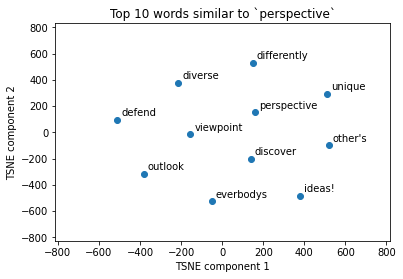

In [27]:
### Continuos Bag of Words 
w2v_cbow_model = Word2Vec(data2emb , min_count=1, size= 50, workers=3, window=3, sg = 0) 
word_labels, arr = get_topn_arr(w2v_cbow_model, test_str, 50) 
display_closestwords_tsnescatterplot(word_labels, arr, f"Top 10 words similar to `{test_str}`") 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


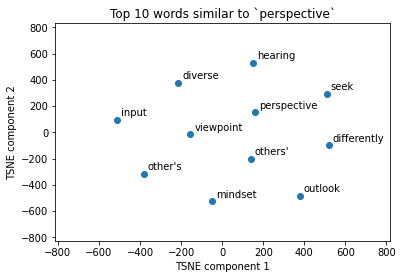

In [28]:
### Skipgrams 
w2v_skp_model = Word2Vec(data2emb , min_count=1, size= 50, workers=3, window=3, sg = 1) 
word_labels, arr = get_topn_arr(w2v_skp_model, test_str, 50)
display_closestwords_tsnescatterplot(word_labels, arr, f"Top 10 words similar to `{test_str}`") 

## BERT sentence embedding

In [30]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.4 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=bc7f846e730c579b773b0cef816cf9b1905cb23181cc89f08afe563630f2852f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [31]:
from sentence_transformers import SentenceTransformer
    
model = SentenceTransformer('bert-base-nli-mean-tokens') 
vectorized_df = pd.DataFrame(model.encode(train['processed_text'].tolist())) 

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'BERT embeddings TSNE')

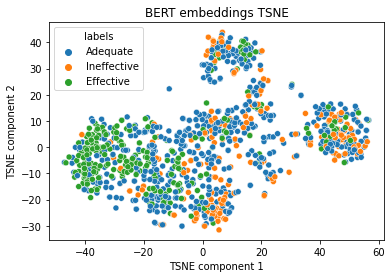

In [32]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(vectorized_df.values[:1000])
x_coords = Y[:, 0]
y_coords = Y[:, 1] 

df = pd.DataFrame()
df['TSNE component 1'] = x_coords
df['TSNE component 2'] = y_coords
df['labels'] = train['discourse_effectiveness']

sns.scatterplot(data=df,x="TSNE component 1",y="TSNE component 2", hue='labels')
plt.title('BERT embeddings TSNE')

# Modelling

In [33]:
gru_model= Sequential()
gru_model.add(Input(shape=(None,)))
gru_model.add(Embedding(5000, 200, mask_zero=True))
gru_model.add(GRU(256, activation='tanh', return_sequences=True))
gru_model.add(GRU(256, activation='tanh', return_sequences=True))
gru_model.add(GRU(256, activation='tanh', return_sequences=False))
gru_model.add(Dense(3, activation='softmax'))

gru_model.summary()

gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_model.fit(X_train, y_train, epochs=2, batch_size=256)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         1000000   
                                                                 
 gru (GRU)                   (None, None, 256)         351744    
                                                                 
 gru_1 (GRU)                 (None, None, 256)         394752    
                                                                 
 gru_2 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,142,019
Trainable params: 2,142,019
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
144/144 [===========================

In [35]:
lstm_model= Sequential()
lstm_model.add(Input(shape=(None,)))
lstm_model.add(Embedding(5000, 200, mask_zero=True))
lstm_model.add(LSTM(256, activation='tanh', return_sequences=True))
lstm_model.add(LSTM(256, activation='tanh', return_sequences=False))
lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=2, batch_size=256)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 200)         1000000   
                                                                 
 lstm_2 (LSTM)               (None, None, 256)         467968    
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dense_2 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,994,051
Trainable params: 1,994,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
144/144 [==============================] - 58s 352ms/step - loss: 0.9741 - accuracy: 0.5702
Epoch 2/2
144/144 [==============================] - 51s 357ms/step - loss

In [ ]:
# saving model
#lstm_model.save('debate_model_new3.h5', save_format='h5')

# Transformers

In [38]:
DEBUG = False
train_df = pd.read_csv('/content/train.csv')
if DEBUG:
    test_df = pd.read_csv('/content/train.csv')
else:
    test_df = pd.read_csv('/content/test.csv')

In [39]:
train_df["label"] = train_df["discourse_effectiveness"].replace({"Ineffective": 0, "Adequate": 1, "Effective": 2})

In [43]:
def preprocess_function(x_data, tokenizer, max_len=256):
    token = tokenizer(list(x_data.astype(str).values), truncation=True, padding='longest', add_special_tokens=True)
    return np.array(token['input_ids']), np.array(token['attention_mask']), np.array(token['token_type_ids'])

## BERT Cased

In [44]:
model_checkpoint = 'bert-base-cased'
batch_size = 16

In [45]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.model_max_length = 256

In [46]:
sep = tokenizer.sep_token

In [47]:
train_df['inputs'] = train_df.discourse_type + ' ' + sep + ' ' + train_df.discourse_text

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df['inputs'], train_df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [49]:
X_train = preprocess_function(X_train, tokenizer)
X_val = preprocess_function(X_val, tokenizer)

y_train = y_train.values
y_val = y_val.values

In [50]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

In [51]:
from transformers import TFAutoModelForSequenceClassification

num_labels = 3
label2id = {"Ineffective": 0, "Adequate": 1, "Effective": 2}

id2label = {val: key for key, val in label2id.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
from transformers import create_optimizer

num_epochs = 2
batches_per_epoch = 200
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=20, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy',)

In [53]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 108,312,579
Trainable params: 108,312,579
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=200,
    epochs=num_epochs,
)

Epoch 1/2
200/200 [==============================] - 298s 1s/step - loss: 3.2589 - accuracy: 0.3741 - val_loss: 1.0986 - val_accuracy: 0.2563
Epoch 2/2
200/200 [==============================] - 268s 1s/step - loss: 1.1149 - accuracy: 0.3131 - val_loss: 1.0986 - val_accuracy: 0.2614


230/230 [==============================] - 132s 561ms/step


Text(0.5, 1.0, 'Confusion Matrix - BERT')

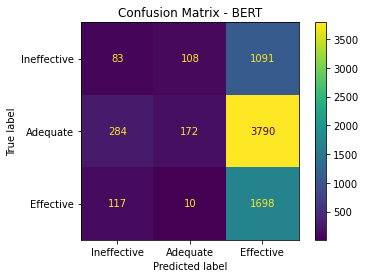

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = preprocess_function(X_test, tokenizer)
preds = model.predict(X_test, verbose=1)
y_pred = np.argmax(preds.logits, axis=-1)
y_true = y_test.values
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ineffective', 'Adequate', 'Effective'])
disp.plot()
plt.title('Confusion Matrix - BERT')

Text(0.5, 1.0, 'Model Performance - BERT Base')

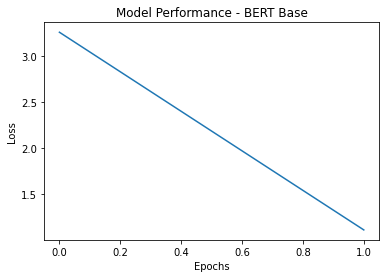

In [56]:
plt.plot(range(num_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance - BERT Base')

Text(0.5, 1.0, 'Model Performance - BERT Base')

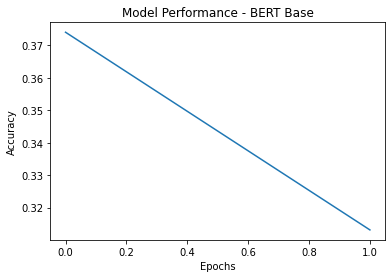

In [57]:
plt.plot(range(num_epochs), history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance - BERT Base')

## Deberta V3 XSmall 

In [58]:
model_checkpoint = 'microsoft/deberta-v3-xsmall'
batch_size = 16

In [59]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.model_max_length = 256

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:
sep = tokenizer.sep_token

In [61]:
train_df['inputs'] = train_df.discourse_type + ' ' + sep + ' ' + train_df.discourse_text

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df['inputs'], train_df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [63]:
X_train = preprocess_function(X_train, tokenizer)
X_val = preprocess_function(X_val, tokenizer)

y_train = y_train.values
y_val = y_val.values

In [64]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

In [65]:
num_labels = 3
label2id = {"Ineffective": 0, "Adequate": 1, "Effective": 2}

id2label = {val: key for key, val in label2id.items()}

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id
)

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['cls_dropout', 'classifier', 'pooler']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
num_epochs = 2
batches_per_epoch = 100
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=20, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy',)

In [67]:
model.summary()

Model: "tf_deberta_v2_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaV2MainLay  multiple                 70682112  
 er)                                                             
                                                                 
 pooler (TFDebertaV2ContextP  multiple                 147840    
 ooler)                                                          
                                                                 
 cls_dropout (TFDebertaV2Sta  multiple                 0         
 bleDropout)                                                     
                                                                 
 classifier (Dense)          multiple                  1155      
                                                                 
Total params: 70,831,107
Trainable params: 70,831,107
Non-trainable params: 0
_____________

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    steps_per_epoch=200,
    epochs=num_epochs,
)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = preprocess_function(X_test, tokenizer)
preds = model.predict(X_test, verbose=1)
y_pred = np.argmax(preds.logits, axis=-1)
y_true = y_test.values
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ineffective', 'Adequate', 'Effective'])
disp.plot()
plt.title('Confusion Matrix - DEBERTA')

In [ ]:
plt.plot(range(num_epochs), history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance - BERT Base')

In [ ]:
plt.plot(range(num_epochs), history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Performance - BERT Base')

## Conclusion

1. The accuracies are decreasing for DEBERTA model despite the loss converging. However, BERT model is performs better in this aspect with accuracies increasing on training. The final validation losses are comparable for both these models.
2. Data Imbalance is one of the reasons for poor model performance.


## Future Scope

1. Proper handling of imbalance in the data can result in a better scope of results.
2. The data gathered for the problem statement seemed insufficient for the model to train on.
3. Ensembling complex NLP models may provide a better result.
4. Although DeBerta is implemented its performance is quite poor since we have used the extra small version due to shortage of resources to train a larger model. While compared to that BERT has almost 1.5 times more learning parameters.
